In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py

2023-09-26 17:47:26.449645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 17:47:26.757633: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-26 17:47:26.757661: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-26 17:47:27.999788: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
f = h5py.File("../data/quark-gluon_train-set_n793900.hdf5","r")

In [3]:
x_train = f.get('X_jets')
y_train = f.get('y')

In [4]:
size = 3
Nvals = 2
Nsamples = 100000
file_name = "QG_train_normalized_N3_M2_bilinear_xl"

In [5]:
def discretize_img(img):
    bins = np.linspace(0,1,Nvals+1)
    vals = np.linspace(0,1,Nvals)
    inds = np.digitize(img, bins)
    return vals[inds-1]

In [6]:
def crop_and_resize(x, channel, scale, crop_fraction=0.8,meth="bilinear"):
    cropped = tf.image.central_crop(x[:,:,:,channel].reshape(x.shape[0],125,125,1), crop_fraction)
    return tf.image.resize(cropped, (scale,scale), method=meth).numpy()

In [7]:
scale = size
channel = 1

batch_size = 200
num_batches = Nsamples//batch_size

events = num_batches*batch_size

fnew = h5py.File(file_name, "w")

dsetx = fnew.create_dataset("X", (events,scale,scale), dtype='f')
dsety = fnew.create_dataset("y", (events,), dtype='i')
 
for i in range(int(num_batches)):
    y = y_train[i * batch_size: (i + 1) * batch_size]
    x = x_train[i * batch_size: (i + 1) * batch_size]
    
    #div1 = np.max(x, axis=(1,2)).reshape((batch_size,1,1,3))
    #div1[div1 == 0] = 1
    #x = x / (div1+0.00001)
    
    x_train_small = crop_and_resize(x, channel, scale, crop_fraction=0.7)#, meth="lanczos5")
    
    div1 = np.max(x_train_small, axis=(1,2)).reshape((batch_size,1,1,1))
    div1[div1 == 0] = 1
    x_train_small = x_train_small / (div1+0.00001)
    
    x_discr = discretize_img(x_train_small)
    
    dsety[i * batch_size: (i + 1) * batch_size] = y
    dsetx[i * batch_size: (i + 1) * batch_size] = x_discr.reshape((x_discr.shape[0], scale, scale))
    print("batch ",i,"/",num_batches, end="\r")
    
fnew.close()

2023-09-26 17:47:34.074905: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-09-26 17:47:34.075572: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-26 17:47:34.075605: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2023-09-26 17:47:34.077779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
fnew.close()

In [9]:
ftest = h5py.File(file_name,"r")

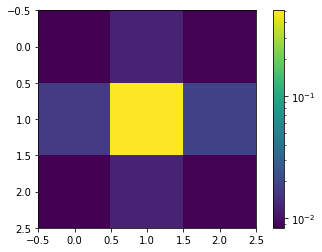

In [10]:
import matplotlib
plt.imshow(np.mean(ftest['X'],axis=0),norm=matplotlib.colors.LogNorm())
plt.colorbar()

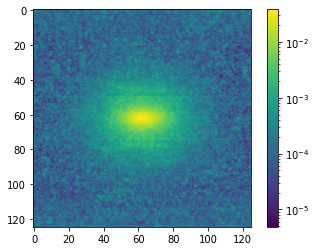

In [11]:
div1 = np.max(x_train[:3000,:,:,1], axis=(1,2)).reshape((3000,1,1))
div1[div1 == 0] = 1
#x = x / (div1+0.00001)

plt.imshow(np.mean(x_train[:3000,:,:,1]/div1+0.0000001,axis=0),norm=matplotlib.colors.LogNorm())
plt.colorbar()

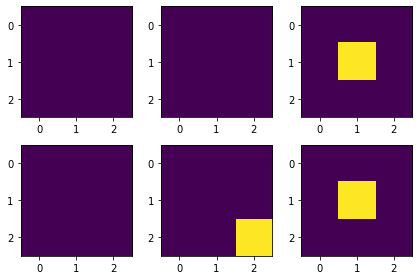

In [12]:
fig, ax = plt.subplots(2, 3)
nums = np.random.randint(0,Nsamples,size=(6,))
ax[0,0].imshow(ftest['X'][nums[0]])
ax[0,1].imshow(ftest['X'][nums[1]])
ax[0,2].imshow(ftest['X'][nums[2]])
ax[1,0].imshow(ftest['X'][nums[3]])
ax[1,1].imshow(ftest['X'][nums[4]])
ax[1,2].imshow(ftest['X'][nums[5]])
fig.tight_layout()

In [13]:
ftest.close()

## stuff